In [1]:
import sys
import os

# Step 1: Get current directory 
current_directory = os.getcwd()        # '/home/bear-b/users/jshi008/IvyProjects/FIDLA/train_WaLeF_models'

# Step 2: Get path of parent directory (one level up)
parent_directory = os.path.dirname(current_directory)    # '/home/bear-b/users/jshi008/IvyProjects/FIDLA'

# Step 3: Append parent directory to sys.path
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from preprocess.BaselinePrerocess import baseline_process
from baselines.mlp import mlp

2023-08-10 22:19:11.407484: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 22:19:12.817794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

### Preprocess

In [10]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9

train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


### Model

In [14]:
# ===== model parameters ======
mlp_unit1 = 64
mlp_unit2 = 16
dropout = 0.1
l1_reg = 1e-5
l2_reg = 1e-5
learning_rate = 1e-3
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512
input_shape = train_X_mask.shape[1:]

In [15]:
model = mlp(input_shape, mlp_unit1, mlp_unit2, l1_reg, l2_reg, dropout, masked_value)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 16)]          0         
                                                                 
 masking_2 (Masking)         (None, 96, 16)            0         
                                                                 
 dense_6 (Dense)             (None, 96, 64)            1088      
                                                                 
 dropout_2 (Dropout)         (None, 96, 64)            0         
                                                                 
 dense_7 (Dense)             (None, 96, 16)            1040      
                                                                 
 flatten_2 (Flatten)         (None, 1536)              0         
                                                                 
 dense_8 (Dense)             (None, 96)                1475

In [16]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../saved_models/WaLeF_mlp.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True
                    )


model.fit([train_X_mask], train_ws_y,
          validation_data=([test_X_mask], test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000

Epoch 1: val_mae improved from inf to 0.06448, saving model to ../saved_models/WaLeF_mlp.h5
151/151 - 3s - loss: 0.0118 - mae: 0.0627 - val_loss: 0.0092 - val_mae: 0.0645 - 3s/epoch - 19ms/step
Epoch 2/3000

Epoch 2: val_mae improved from 0.06448 to 0.03783, saving model to ../saved_models/WaLeF_mlp.h5
151/151 - 1s - loss: 0.0042 - mae: 0.0311 - val_loss: 0.0045 - val_mae: 0.0378 - 916ms/epoch - 6ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.03783 to 0.03297, saving model to ../saved_models/WaLeF_mlp.h5
151/151 - 1s - loss: 0.0031 - mae: 0.0229 - val_loss: 0.0037 - val_mae: 0.0330 - 924ms/epoch - 6ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.03297 to 0.03151, saving model to ../saved_models/WaLeF_mlp.h5
151/151 - 1s - loss: 0.0026 - mae: 0.0191 - val_loss: 0.0033 - val_mae: 0.0315 - 955ms/epoch - 6ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.03151 to 0.03087, saving model to ../saved_models/WaLeF_mlp.h5
151/151 - 1s - loss: 0.0023 - mae: 0.017

Epoch 45/3000

Epoch 45: val_mae did not improve from 0.02735
151/151 - 1s - loss: 4.0309e-04 - mae: 0.0111 - val_loss: 0.0013 - val_mae: 0.0276 - 886ms/epoch - 6ms/step
Epoch 46/3000

Epoch 46: val_mae did not improve from 0.02735
151/151 - 1s - loss: 4.0076e-04 - mae: 0.0111 - val_loss: 0.0013 - val_mae: 0.0275 - 904ms/epoch - 6ms/step
Epoch 47/3000

Epoch 47: val_mae did not improve from 0.02735
151/151 - 1s - loss: 3.9850e-04 - mae: 0.0110 - val_loss: 0.0013 - val_mae: 0.0282 - 860ms/epoch - 6ms/step
Epoch 48/3000

Epoch 48: val_mae did not improve from 0.02735
151/151 - 1s - loss: 3.9682e-04 - mae: 0.0110 - val_loss: 0.0013 - val_mae: 0.0278 - 907ms/epoch - 6ms/step
Epoch 49/3000

Epoch 49: val_mae did not improve from 0.02735
151/151 - 1s - loss: 3.9310e-04 - mae: 0.0109 - val_loss: 0.0013 - val_mae: 0.0281 - 883ms/epoch - 6ms/step
Epoch 50/3000

Epoch 50: val_mae did not improve from 0.02735
151/151 - 1s - loss: 3.9308e-04 - mae: 0.0109 - val_loss: 0.0014 - val_mae: 0.0285 - 871

151/151 - 1s - loss: 3.4985e-04 - mae: 0.0103 - val_loss: 0.0012 - val_mae: 0.0267 - 859ms/epoch - 6ms/step
Epoch 91/3000

Epoch 91: val_mae did not improve from 0.02608
151/151 - 1s - loss: 3.4950e-04 - mae: 0.0103 - val_loss: 0.0012 - val_mae: 0.0269 - 874ms/epoch - 6ms/step
Epoch 92/3000

Epoch 92: val_mae did not improve from 0.02608
151/151 - 1s - loss: 3.4766e-04 - mae: 0.0102 - val_loss: 0.0012 - val_mae: 0.0270 - 895ms/epoch - 6ms/step
Epoch 93/3000

Epoch 93: val_mae did not improve from 0.02608
151/151 - 1s - loss: 3.4736e-04 - mae: 0.0102 - val_loss: 0.0012 - val_mae: 0.0270 - 884ms/epoch - 6ms/step
Epoch 94/3000

Epoch 94: val_mae did not improve from 0.02608
151/151 - 1s - loss: 3.4708e-04 - mae: 0.0102 - val_loss: 0.0012 - val_mae: 0.0264 - 882ms/epoch - 6ms/step
Epoch 95/3000

Epoch 95: val_mae did not improve from 0.02608
151/151 - 1s - loss: 3.4784e-04 - mae: 0.0103 - val_loss: 0.0012 - val_mae: 0.0266 - 879ms/epoch - 6ms/step
Epoch 96/3000

Epoch 96: val_mae did not i

Epoch 138/3000

Epoch 138: val_mae did not improve from 0.02575
151/151 - 1s - loss: 3.2918e-04 - mae: 0.0100 - val_loss: 0.0011 - val_mae: 0.0263 - 885ms/epoch - 6ms/step
Epoch 139/3000

Epoch 139: val_mae did not improve from 0.02575
151/151 - 1s - loss: 3.3086e-04 - mae: 0.0101 - val_loss: 0.0011 - val_mae: 0.0259 - 912ms/epoch - 6ms/step
Epoch 140/3000

Epoch 140: val_mae did not improve from 0.02575
151/151 - 1s - loss: 3.2770e-04 - mae: 0.0100 - val_loss: 0.0011 - val_mae: 0.0264 - 894ms/epoch - 6ms/step
Epoch 141/3000

Epoch 141: val_mae did not improve from 0.02575
151/151 - 1s - loss: 3.2831e-04 - mae: 0.0100 - val_loss: 0.0011 - val_mae: 0.0265 - 908ms/epoch - 6ms/step
Epoch 142/3000

Epoch 142: val_mae did not improve from 0.02575
151/151 - 1s - loss: 3.2716e-04 - mae: 0.0100 - val_loss: 0.0012 - val_mae: 0.0266 - 885ms/epoch - 6ms/step
Epoch 143/3000

Epoch 143: val_mae did not improve from 0.02575
151/151 - 1s - loss: 3.2926e-04 - mae: 0.0100 - val_loss: 0.0012 - val_mae: 

Epoch 184/3000

Epoch 184: val_mae did not improve from 0.02459
151/151 - 1s - loss: 3.1774e-04 - mae: 0.0098 - val_loss: 0.0010 - val_mae: 0.0251 - 902ms/epoch - 6ms/step
Epoch 185/3000

Epoch 185: val_mae did not improve from 0.02459
151/151 - 1s - loss: 3.1499e-04 - mae: 0.0097 - val_loss: 0.0010 - val_mae: 0.0248 - 913ms/epoch - 6ms/step
Epoch 186/3000

Epoch 186: val_mae did not improve from 0.02459
151/151 - 1s - loss: 3.1528e-04 - mae: 0.0098 - val_loss: 9.9821e-04 - val_mae: 0.0247 - 890ms/epoch - 6ms/step
Epoch 187/3000

Epoch 187: val_mae did not improve from 0.02459
151/151 - 1s - loss: 3.1507e-04 - mae: 0.0098 - val_loss: 0.0011 - val_mae: 0.0257 - 903ms/epoch - 6ms/step
Epoch 188/3000

Epoch 188: val_mae improved from 0.02459 to 0.02443, saving model to ../saved_models/WaLeF_mlp.h5
151/151 - 1s - loss: 3.1580e-04 - mae: 0.0098 - val_loss: 9.7463e-04 - val_mae: 0.0244 - 917ms/epoch - 6ms/step
Epoch 189/3000

Epoch 189: val_mae did not improve from 0.02443
151/151 - 1s - los

Epoch 228/3000

Epoch 228: val_mae did not improve from 0.02215
151/151 - 1s - loss: 3.0632e-04 - mae: 0.0096 - val_loss: 8.3752e-04 - val_mae: 0.0223 - 896ms/epoch - 6ms/step
Epoch 229/3000

Epoch 229: val_mae improved from 0.02215 to 0.02189, saving model to ../saved_models/WaLeF_mlp.h5
151/151 - 1s - loss: 3.0781e-04 - mae: 0.0097 - val_loss: 8.2176e-04 - val_mae: 0.0219 - 974ms/epoch - 6ms/step
Epoch 230/3000

Epoch 230: val_mae did not improve from 0.02189
151/151 - 1s - loss: 3.0590e-04 - mae: 0.0096 - val_loss: 8.1214e-04 - val_mae: 0.0220 - 922ms/epoch - 6ms/step
Epoch 231/3000

Epoch 231: val_mae did not improve from 0.02189
151/151 - 1s - loss: 3.0598e-04 - mae: 0.0096 - val_loss: 8.2381e-04 - val_mae: 0.0223 - 906ms/epoch - 6ms/step
Epoch 232/3000

Epoch 232: val_mae did not improve from 0.02189
151/151 - 1s - loss: 3.0549e-04 - mae: 0.0096 - val_loss: 8.2864e-04 - val_mae: 0.0223 - 886ms/epoch - 6ms/step
Epoch 233/3000

Epoch 233: val_mae did not improve from 0.02189
151/15

Epoch 274/3000

Epoch 274: val_mae did not improve from 0.02083
151/151 - 1s - loss: 2.9761e-04 - mae: 0.0094 - val_loss: 8.0635e-04 - val_mae: 0.0216 - 871ms/epoch - 6ms/step
Epoch 275/3000

Epoch 275: val_mae did not improve from 0.02083
151/151 - 1s - loss: 2.9711e-04 - mae: 0.0094 - val_loss: 7.9769e-04 - val_mae: 0.0213 - 877ms/epoch - 6ms/step
Epoch 276/3000

Epoch 276: val_mae did not improve from 0.02083
151/151 - 1s - loss: 2.9728e-04 - mae: 0.0094 - val_loss: 7.8906e-04 - val_mae: 0.0213 - 906ms/epoch - 6ms/step
Epoch 277/3000

Epoch 277: val_mae did not improve from 0.02083
151/151 - 1s - loss: 2.9817e-04 - mae: 0.0095 - val_loss: 7.8928e-04 - val_mae: 0.0213 - 880ms/epoch - 6ms/step
Epoch 278/3000

Epoch 278: val_mae improved from 0.02083 to 0.02080, saving model to ../saved_models/WaLeF_mlp.h5
151/151 - 1s - loss: 2.9600e-04 - mae: 0.0094 - val_loss: 7.7895e-04 - val_mae: 0.0208 - 966ms/epoch - 6ms/step
Epoch 279/3000

Epoch 279: val_mae did not improve from 0.02080
151/15

Epoch 320/3000

Epoch 320: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.8988e-04 - mae: 0.0093 - val_loss: 8.0045e-04 - val_mae: 0.0218 - 879ms/epoch - 6ms/step
Epoch 321/3000

Epoch 321: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.8990e-04 - mae: 0.0093 - val_loss: 7.5915e-04 - val_mae: 0.0206 - 905ms/epoch - 6ms/step
Epoch 322/3000

Epoch 322: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.8998e-04 - mae: 0.0093 - val_loss: 8.1261e-04 - val_mae: 0.0218 - 887ms/epoch - 6ms/step
Epoch 323/3000

Epoch 323: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.9030e-04 - mae: 0.0093 - val_loss: 7.7433e-04 - val_mae: 0.0210 - 902ms/epoch - 6ms/step
Epoch 324/3000

Epoch 324: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.8937e-04 - mae: 0.0093 - val_loss: 8.0549e-04 - val_mae: 0.0219 - 887ms/epoch - 6ms/step
Epoch 325/3000

Epoch 325: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.8929e-04 - mae: 0.0093 - val_loss

Epoch 367/3000

Epoch 367: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.8462e-04 - mae: 0.0093 - val_loss: 7.8418e-04 - val_mae: 0.0213 - 901ms/epoch - 6ms/step
Epoch 368/3000

Epoch 368: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.8354e-04 - mae: 0.0092 - val_loss: 7.8393e-04 - val_mae: 0.0212 - 873ms/epoch - 6ms/step
Epoch 369/3000

Epoch 369: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.8276e-04 - mae: 0.0092 - val_loss: 7.8640e-04 - val_mae: 0.0214 - 855ms/epoch - 6ms/step
Epoch 370/3000

Epoch 370: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.8363e-04 - mae: 0.0092 - val_loss: 7.7156e-04 - val_mae: 0.0208 - 878ms/epoch - 6ms/step
Epoch 371/3000

Epoch 371: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.8288e-04 - mae: 0.0092 - val_loss: 8.0384e-04 - val_mae: 0.0219 - 890ms/epoch - 6ms/step
Epoch 372/3000

Epoch 372: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.8404e-04 - mae: 0.0092 - val_loss

Epoch 414/3000

Epoch 414: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7837e-04 - mae: 0.0091 - val_loss: 7.8844e-04 - val_mae: 0.0215 - 904ms/epoch - 6ms/step
Epoch 415/3000

Epoch 415: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.8097e-04 - mae: 0.0092 - val_loss: 8.1592e-04 - val_mae: 0.0221 - 890ms/epoch - 6ms/step
Epoch 416/3000

Epoch 416: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7920e-04 - mae: 0.0092 - val_loss: 7.7414e-04 - val_mae: 0.0209 - 936ms/epoch - 6ms/step
Epoch 417/3000

Epoch 417: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7955e-04 - mae: 0.0092 - val_loss: 7.8815e-04 - val_mae: 0.0213 - 903ms/epoch - 6ms/step
Epoch 418/3000

Epoch 418: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7906e-04 - mae: 0.0092 - val_loss: 7.8644e-04 - val_mae: 0.0216 - 902ms/epoch - 6ms/step
Epoch 419/3000

Epoch 419: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7916e-04 - mae: 0.0092 - val_loss

Epoch 461/3000

Epoch 461: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7798e-04 - mae: 0.0092 - val_loss: 8.2012e-04 - val_mae: 0.0223 - 883ms/epoch - 6ms/step
Epoch 462/3000

Epoch 462: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7636e-04 - mae: 0.0092 - val_loss: 7.8085e-04 - val_mae: 0.0210 - 883ms/epoch - 6ms/step
Epoch 463/3000

Epoch 463: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7810e-04 - mae: 0.0092 - val_loss: 7.7055e-04 - val_mae: 0.0209 - 868ms/epoch - 6ms/step
Epoch 464/3000

Epoch 464: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7609e-04 - mae: 0.0091 - val_loss: 7.8207e-04 - val_mae: 0.0213 - 867ms/epoch - 6ms/step
Epoch 465/3000

Epoch 465: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7583e-04 - mae: 0.0091 - val_loss: 8.0573e-04 - val_mae: 0.0217 - 890ms/epoch - 6ms/step
Epoch 466/3000

Epoch 466: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7704e-04 - mae: 0.0092 - val_loss

Epoch 508/3000

Epoch 508: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7506e-04 - mae: 0.0092 - val_loss: 7.6733e-04 - val_mae: 0.0212 - 867ms/epoch - 6ms/step
Epoch 509/3000

Epoch 509: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7405e-04 - mae: 0.0091 - val_loss: 7.8052e-04 - val_mae: 0.0213 - 896ms/epoch - 6ms/step
Epoch 510/3000

Epoch 510: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7305e-04 - mae: 0.0091 - val_loss: 7.7178e-04 - val_mae: 0.0211 - 900ms/epoch - 6ms/step
Epoch 511/3000

Epoch 511: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7314e-04 - mae: 0.0091 - val_loss: 7.8155e-04 - val_mae: 0.0211 - 889ms/epoch - 6ms/step
Epoch 512/3000

Epoch 512: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7340e-04 - mae: 0.0091 - val_loss: 7.7455e-04 - val_mae: 0.0214 - 888ms/epoch - 6ms/step
Epoch 513/3000

Epoch 513: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7347e-04 - mae: 0.0091 - val_loss

Epoch 555/3000

Epoch 555: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7090e-04 - mae: 0.0091 - val_loss: 7.8814e-04 - val_mae: 0.0215 - 895ms/epoch - 6ms/step
Epoch 556/3000

Epoch 556: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7200e-04 - mae: 0.0091 - val_loss: 7.8004e-04 - val_mae: 0.0213 - 879ms/epoch - 6ms/step
Epoch 557/3000

Epoch 557: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7062e-04 - mae: 0.0091 - val_loss: 7.5713e-04 - val_mae: 0.0208 - 885ms/epoch - 6ms/step
Epoch 558/3000

Epoch 558: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7045e-04 - mae: 0.0091 - val_loss: 7.9140e-04 - val_mae: 0.0216 - 868ms/epoch - 6ms/step
Epoch 559/3000

Epoch 559: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7119e-04 - mae: 0.0091 - val_loss: 7.7108e-04 - val_mae: 0.0211 - 901ms/epoch - 6ms/step
Epoch 560/3000

Epoch 560: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.7157e-04 - mae: 0.0091 - val_loss

Epoch 602/3000

Epoch 602: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.6888e-04 - mae: 0.0090 - val_loss: 7.5800e-04 - val_mae: 0.0206 - 867ms/epoch - 6ms/step
Epoch 603/3000

Epoch 603: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.6940e-04 - mae: 0.0091 - val_loss: 7.8263e-04 - val_mae: 0.0215 - 874ms/epoch - 6ms/step
Epoch 604/3000

Epoch 604: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.6928e-04 - mae: 0.0091 - val_loss: 8.1204e-04 - val_mae: 0.0219 - 897ms/epoch - 6ms/step
Epoch 605/3000

Epoch 605: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.6867e-04 - mae: 0.0091 - val_loss: 8.0409e-04 - val_mae: 0.0218 - 904ms/epoch - 6ms/step
Epoch 606/3000

Epoch 606: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.6886e-04 - mae: 0.0091 - val_loss: 7.7447e-04 - val_mae: 0.0211 - 894ms/epoch - 6ms/step
Epoch 607/3000

Epoch 607: val_mae did not improve from 0.02047
151/151 - 1s - loss: 2.6914e-04 - mae: 0.0091 - val_loss

151/151 - 1s - loss: 2.6825e-04 - mae: 0.0091 - val_loss: 7.6598e-04 - val_mae: 0.0210 - 902ms/epoch - 6ms/step
Epoch 649/3000

Epoch 649: val_mae did not improve from 0.02045
151/151 - 1s - loss: 2.6707e-04 - mae: 0.0090 - val_loss: 7.7502e-04 - val_mae: 0.0213 - 887ms/epoch - 6ms/step
Epoch 650/3000

Epoch 650: val_mae did not improve from 0.02045
151/151 - 1s - loss: 2.6716e-04 - mae: 0.0090 - val_loss: 7.9669e-04 - val_mae: 0.0217 - 902ms/epoch - 6ms/step
Epoch 651/3000

Epoch 651: val_mae did not improve from 0.02045
151/151 - 1s - loss: 2.6643e-04 - mae: 0.0090 - val_loss: 7.6458e-04 - val_mae: 0.0210 - 909ms/epoch - 6ms/step
Epoch 652/3000

Epoch 652: val_mae did not improve from 0.02045
151/151 - 1s - loss: 2.6764e-04 - mae: 0.0091 - val_loss: 7.7451e-04 - val_mae: 0.0212 - 874ms/epoch - 6ms/step
Epoch 653/3000

Epoch 653: val_mae did not improve from 0.02045
151/151 - 1s - loss: 2.6865e-04 - mae: 0.0091 - val_loss: 7.8162e-04 - val_mae: 0.0214 - 906ms/epoch - 6ms/step
Epoch 65

Epoch 695/3000

Epoch 695: val_mae did not improve from 0.02036
151/151 - 1s - loss: 2.6501e-04 - mae: 0.0090 - val_loss: 7.7925e-04 - val_mae: 0.0215 - 912ms/epoch - 6ms/step
Epoch 696/3000

Epoch 696: val_mae did not improve from 0.02036
151/151 - 1s - loss: 2.6582e-04 - mae: 0.0090 - val_loss: 7.5795e-04 - val_mae: 0.0210 - 892ms/epoch - 6ms/step
Epoch 697/3000

Epoch 697: val_mae did not improve from 0.02036
151/151 - 1s - loss: 2.6640e-04 - mae: 0.0091 - val_loss: 7.6671e-04 - val_mae: 0.0209 - 898ms/epoch - 6ms/step
Epoch 698/3000

Epoch 698: val_mae did not improve from 0.02036
151/151 - 1s - loss: 2.6524e-04 - mae: 0.0090 - val_loss: 8.1869e-04 - val_mae: 0.0222 - 892ms/epoch - 6ms/step
Epoch 699/3000

Epoch 699: val_mae did not improve from 0.02036
151/151 - 1s - loss: 2.6662e-04 - mae: 0.0091 - val_loss: 7.7349e-04 - val_mae: 0.0213 - 876ms/epoch - 6ms/step
Epoch 700/3000

Epoch 700: val_mae did not improve from 0.02036
151/151 - 1s - loss: 2.6530e-04 - mae: 0.0090 - val_loss

Epoch 742/3000

Epoch 742: val_mae did not improve from 0.02036
151/151 - 1s - loss: 2.6508e-04 - mae: 0.0091 - val_loss: 7.4429e-04 - val_mae: 0.0206 - 864ms/epoch - 6ms/step
Epoch 743/3000

Epoch 743: val_mae did not improve from 0.02036
151/151 - 1s - loss: 2.6482e-04 - mae: 0.0090 - val_loss: 7.6295e-04 - val_mae: 0.0211 - 866ms/epoch - 6ms/step
Epoch 744/3000

Epoch 744: val_mae did not improve from 0.02036
151/151 - 1s - loss: 2.6443e-04 - mae: 0.0090 - val_loss: 7.4847e-04 - val_mae: 0.0209 - 888ms/epoch - 6ms/step
Epoch 745/3000

Epoch 745: val_mae did not improve from 0.02036
151/151 - 1s - loss: 2.6383e-04 - mae: 0.0090 - val_loss: 7.7580e-04 - val_mae: 0.0212 - 905ms/epoch - 6ms/step
Epoch 746/3000

Epoch 746: val_mae did not improve from 0.02036
151/151 - 1s - loss: 2.6352e-04 - mae: 0.0090 - val_loss: 7.5474e-04 - val_mae: 0.0209 - 876ms/epoch - 6ms/step
Epoch 747/3000

Epoch 747: val_mae did not improve from 0.02036
151/151 - 1s - loss: 2.6425e-04 - mae: 0.0090 - val_loss

Epoch 789/3000

Epoch 789: val_mae did not improve from 0.02036
151/151 - 1s - loss: 2.6215e-04 - mae: 0.0090 - val_loss: 7.6415e-04 - val_mae: 0.0210 - 867ms/epoch - 6ms/step
Epoch 790/3000

Epoch 790: val_mae did not improve from 0.02036
151/151 - 1s - loss: 2.6342e-04 - mae: 0.0090 - val_loss: 7.6875e-04 - val_mae: 0.0211 - 877ms/epoch - 6ms/step
Epoch 791/3000

Epoch 791: val_mae did not improve from 0.02036
151/151 - 1s - loss: 2.6409e-04 - mae: 0.0091 - val_loss: 8.0279e-04 - val_mae: 0.0217 - 854ms/epoch - 6ms/step
Epoch 792/3000

Epoch 792: val_mae did not improve from 0.02036
151/151 - 1s - loss: 2.6277e-04 - mae: 0.0090 - val_loss: 7.6690e-04 - val_mae: 0.0212 - 858ms/epoch - 6ms/step
Epoch 793/3000

Epoch 793: val_mae did not improve from 0.02036
151/151 - 1s - loss: 2.6206e-04 - mae: 0.0090 - val_loss: 7.4700e-04 - val_mae: 0.0207 - 866ms/epoch - 6ms/step
Epoch 794/3000

Epoch 794: val_mae did not improve from 0.02036
151/151 - 1s - loss: 2.6155e-04 - mae: 0.0090 - val_loss

Epoch 835/3000

Epoch 835: val_mae did not improve from 0.02008
151/151 - 1s - loss: 2.6288e-04 - mae: 0.0090 - val_loss: 7.6943e-04 - val_mae: 0.0211 - 924ms/epoch - 6ms/step
Epoch 836/3000

Epoch 836: val_mae did not improve from 0.02008
151/151 - 1s - loss: 2.6139e-04 - mae: 0.0090 - val_loss: 7.5180e-04 - val_mae: 0.0207 - 916ms/epoch - 6ms/step
Epoch 837/3000

Epoch 837: val_mae did not improve from 0.02008
151/151 - 1s - loss: 2.6179e-04 - mae: 0.0090 - val_loss: 7.6911e-04 - val_mae: 0.0211 - 887ms/epoch - 6ms/step
Epoch 838/3000

Epoch 838: val_mae did not improve from 0.02008
151/151 - 1s - loss: 2.6148e-04 - mae: 0.0090 - val_loss: 7.4951e-04 - val_mae: 0.0208 - 872ms/epoch - 6ms/step
Epoch 839/3000

Epoch 839: val_mae improved from 0.02008 to 0.01994, saving model to ../saved_models/WaLeF_mlp.h5
151/151 - 1s - loss: 2.6249e-04 - mae: 0.0090 - val_loss: 7.2288e-04 - val_mae: 0.0199 - 907ms/epoch - 6ms/step
Epoch 840/3000

Epoch 840: val_mae did not improve from 0.01994
151/15

Epoch 881/3000

Epoch 881: val_mae did not improve from 0.01991
151/151 - 1s - loss: 2.6025e-04 - mae: 0.0090 - val_loss: 7.6147e-04 - val_mae: 0.0209 - 858ms/epoch - 6ms/step
Epoch 882/3000

Epoch 882: val_mae did not improve from 0.01991
151/151 - 1s - loss: 2.6165e-04 - mae: 0.0090 - val_loss: 7.3661e-04 - val_mae: 0.0205 - 896ms/epoch - 6ms/step
Epoch 883/3000

Epoch 883: val_mae did not improve from 0.01991
151/151 - 1s - loss: 2.6070e-04 - mae: 0.0090 - val_loss: 8.0663e-04 - val_mae: 0.0215 - 871ms/epoch - 6ms/step
Epoch 884/3000

Epoch 884: val_mae did not improve from 0.01991
151/151 - 1s - loss: 2.5988e-04 - mae: 0.0090 - val_loss: 7.7584e-04 - val_mae: 0.0212 - 889ms/epoch - 6ms/step
Epoch 885/3000

Epoch 885: val_mae did not improve from 0.01991
151/151 - 1s - loss: 2.5930e-04 - mae: 0.0090 - val_loss: 7.2981e-04 - val_mae: 0.0202 - 880ms/epoch - 6ms/step
Epoch 886/3000

Epoch 886: val_mae did not improve from 0.01991
151/151 - 1s - loss: 2.6370e-04 - mae: 0.0091 - val_loss

Epoch 927/3000

Epoch 927: val_mae did not improve from 0.01981
151/151 - 1s - loss: 2.5909e-04 - mae: 0.0090 - val_loss: 7.7468e-04 - val_mae: 0.0210 - 877ms/epoch - 6ms/step
Epoch 928/3000

Epoch 928: val_mae did not improve from 0.01981
151/151 - 1s - loss: 2.5926e-04 - mae: 0.0090 - val_loss: 7.2893e-04 - val_mae: 0.0203 - 898ms/epoch - 6ms/step
Epoch 929/3000

Epoch 929: val_mae did not improve from 0.01981
151/151 - 1s - loss: 2.5938e-04 - mae: 0.0090 - val_loss: 7.5556e-04 - val_mae: 0.0209 - 895ms/epoch - 6ms/step
Epoch 930/3000

Epoch 930: val_mae did not improve from 0.01981
151/151 - 1s - loss: 2.5888e-04 - mae: 0.0090 - val_loss: 7.1761e-04 - val_mae: 0.0200 - 869ms/epoch - 6ms/step
Epoch 931/3000

Epoch 931: val_mae did not improve from 0.01981
151/151 - 1s - loss: 2.5880e-04 - mae: 0.0090 - val_loss: 7.8032e-04 - val_mae: 0.0212 - 899ms/epoch - 6ms/step
Epoch 932/3000

Epoch 932: val_mae did not improve from 0.01981
151/151 - 1s - loss: 2.6013e-04 - mae: 0.0090 - val_loss

151/151 - 1s - loss: 2.5832e-04 - mae: 0.0090 - val_loss: 7.5024e-04 - val_mae: 0.0206 - 863ms/epoch - 6ms/step
Epoch 974/3000

Epoch 974: val_mae did not improve from 0.01978
151/151 - 1s - loss: 2.5792e-04 - mae: 0.0090 - val_loss: 7.3645e-04 - val_mae: 0.0205 - 888ms/epoch - 6ms/step
Epoch 975/3000

Epoch 975: val_mae did not improve from 0.01978
151/151 - 1s - loss: 2.6036e-04 - mae: 0.0091 - val_loss: 7.9417e-04 - val_mae: 0.0214 - 857ms/epoch - 6ms/step
Epoch 976/3000

Epoch 976: val_mae did not improve from 0.01978
151/151 - 1s - loss: 2.5781e-04 - mae: 0.0090 - val_loss: 7.3976e-04 - val_mae: 0.0203 - 859ms/epoch - 6ms/step
Epoch 977/3000

Epoch 977: val_mae did not improve from 0.01978
151/151 - 1s - loss: 2.5750e-04 - mae: 0.0090 - val_loss: 7.6704e-04 - val_mae: 0.0208 - 869ms/epoch - 6ms/step
Epoch 978/3000

Epoch 978: val_mae did not improve from 0.01978
151/151 - 1s - loss: 2.5804e-04 - mae: 0.0090 - val_loss: 7.2969e-04 - val_mae: 0.0203 - 863ms/epoch - 6ms/step
Epoch 97

151/151 - 1s - loss: 2.5652e-04 - mae: 0.0090 - val_loss: 7.5360e-04 - val_mae: 0.0205 - 905ms/epoch - 6ms/step
Epoch 1020/3000

Epoch 1020: val_mae did not improve from 0.01952
151/151 - 1s - loss: 2.5709e-04 - mae: 0.0090 - val_loss: 7.2424e-04 - val_mae: 0.0200 - 888ms/epoch - 6ms/step
Epoch 1021/3000

Epoch 1021: val_mae did not improve from 0.01952
151/151 - 1s - loss: 2.5690e-04 - mae: 0.0090 - val_loss: 7.5450e-04 - val_mae: 0.0207 - 915ms/epoch - 6ms/step
Epoch 1022/3000

Epoch 1022: val_mae did not improve from 0.01952
151/151 - 1s - loss: 2.5763e-04 - mae: 0.0090 - val_loss: 7.6021e-04 - val_mae: 0.0206 - 880ms/epoch - 6ms/step
Epoch 1023/3000

Epoch 1023: val_mae did not improve from 0.01952
151/151 - 1s - loss: 2.5812e-04 - mae: 0.0090 - val_loss: 7.5974e-04 - val_mae: 0.0205 - 903ms/epoch - 6ms/step
Epoch 1024/3000

Epoch 1024: val_mae did not improve from 0.01952
151/151 - 1s - loss: 2.5835e-04 - mae: 0.0090 - val_loss: 8.4399e-04 - val_mae: 0.0223 - 881ms/epoch - 6ms/ste

Epoch 1066/3000

Epoch 1066: val_mae did not improve from 0.01952
151/151 - 1s - loss: 2.5621e-04 - mae: 0.0090 - val_loss: 7.4700e-04 - val_mae: 0.0204 - 862ms/epoch - 6ms/step
Epoch 1067/3000

Epoch 1067: val_mae did not improve from 0.01952
151/151 - 1s - loss: 2.5669e-04 - mae: 0.0090 - val_loss: 7.3414e-04 - val_mae: 0.0201 - 884ms/epoch - 6ms/step
Epoch 1068/3000

Epoch 1068: val_mae did not improve from 0.01952
151/151 - 1s - loss: 2.5579e-04 - mae: 0.0089 - val_loss: 7.4521e-04 - val_mae: 0.0202 - 893ms/epoch - 6ms/step
Epoch 1069/3000

Epoch 1069: val_mae did not improve from 0.01952
151/151 - 1s - loss: 2.5702e-04 - mae: 0.0090 - val_loss: 7.5432e-04 - val_mae: 0.0207 - 863ms/epoch - 6ms/step
Epoch 1070/3000

Epoch 1070: val_mae did not improve from 0.01952
151/151 - 1s - loss: 2.5655e-04 - mae: 0.0090 - val_loss: 7.4689e-04 - val_mae: 0.0204 - 881ms/epoch - 6ms/step
Epoch 1071/3000

Epoch 1071: val_mae did not improve from 0.01952
151/151 - 1s - loss: 2.5687e-04 - mae: 0.009

Epoch 1112/3000

Epoch 1112: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5556e-04 - mae: 0.0090 - val_loss: 7.2414e-04 - val_mae: 0.0197 - 873ms/epoch - 6ms/step
Epoch 1113/3000

Epoch 1113: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5665e-04 - mae: 0.0090 - val_loss: 7.8835e-04 - val_mae: 0.0212 - 901ms/epoch - 6ms/step
Epoch 1114/3000

Epoch 1114: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5521e-04 - mae: 0.0089 - val_loss: 7.1800e-04 - val_mae: 0.0198 - 869ms/epoch - 6ms/step
Epoch 1115/3000

Epoch 1115: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5504e-04 - mae: 0.0089 - val_loss: 7.2810e-04 - val_mae: 0.0201 - 858ms/epoch - 6ms/step
Epoch 1116/3000

Epoch 1116: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5504e-04 - mae: 0.0089 - val_loss: 7.2799e-04 - val_mae: 0.0200 - 904ms/epoch - 6ms/step
Epoch 1117/3000

Epoch 1117: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5611e-04 - mae: 0.009


Epoch 1158: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5480e-04 - mae: 0.0089 - val_loss: 7.2339e-04 - val_mae: 0.0200 - 899ms/epoch - 6ms/step
Epoch 1159/3000

Epoch 1159: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5434e-04 - mae: 0.0089 - val_loss: 7.2763e-04 - val_mae: 0.0201 - 867ms/epoch - 6ms/step
Epoch 1160/3000

Epoch 1160: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5447e-04 - mae: 0.0089 - val_loss: 7.5143e-04 - val_mae: 0.0204 - 863ms/epoch - 6ms/step
Epoch 1161/3000

Epoch 1161: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5605e-04 - mae: 0.0090 - val_loss: 7.1910e-04 - val_mae: 0.0198 - 881ms/epoch - 6ms/step
Epoch 1162/3000

Epoch 1162: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5404e-04 - mae: 0.0089 - val_loss: 7.6679e-04 - val_mae: 0.0208 - 886ms/epoch - 6ms/step
Epoch 1163/3000

Epoch 1163: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5543e-04 - mae: 0.0090 - val_loss: 7.

151/151 - 1s - loss: 2.5430e-04 - mae: 0.0090 - val_loss: 7.5148e-04 - val_mae: 0.0205 - 927ms/epoch - 6ms/step
Epoch 1205/3000

Epoch 1205: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5449e-04 - mae: 0.0090 - val_loss: 7.2540e-04 - val_mae: 0.0199 - 897ms/epoch - 6ms/step
Epoch 1206/3000

Epoch 1206: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5459e-04 - mae: 0.0090 - val_loss: 7.1102e-04 - val_mae: 0.0197 - 901ms/epoch - 6ms/step
Epoch 1207/3000

Epoch 1207: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5416e-04 - mae: 0.0090 - val_loss: 7.6055e-04 - val_mae: 0.0206 - 914ms/epoch - 6ms/step
Epoch 1208/3000

Epoch 1208: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5498e-04 - mae: 0.0090 - val_loss: 7.4598e-04 - val_mae: 0.0204 - 856ms/epoch - 6ms/step
Epoch 1209/3000

Epoch 1209: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5410e-04 - mae: 0.0089 - val_loss: 7.9121e-04 - val_mae: 0.0213 - 859ms/epoch - 6ms/ste

Epoch 1251/3000

Epoch 1251: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5307e-04 - mae: 0.0089 - val_loss: 7.5119e-04 - val_mae: 0.0203 - 878ms/epoch - 6ms/step
Epoch 1252/3000

Epoch 1252: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5310e-04 - mae: 0.0089 - val_loss: 7.0576e-04 - val_mae: 0.0195 - 884ms/epoch - 6ms/step
Epoch 1253/3000

Epoch 1253: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5409e-04 - mae: 0.0090 - val_loss: 7.1795e-04 - val_mae: 0.0199 - 880ms/epoch - 6ms/step
Epoch 1254/3000

Epoch 1254: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5402e-04 - mae: 0.0090 - val_loss: 7.2991e-04 - val_mae: 0.0201 - 868ms/epoch - 6ms/step
Epoch 1255/3000

Epoch 1255: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5324e-04 - mae: 0.0089 - val_loss: 7.2217e-04 - val_mae: 0.0197 - 865ms/epoch - 6ms/step
Epoch 1256/3000

Epoch 1256: val_mae did not improve from 0.01929
151/151 - 1s - loss: 2.5332e-04 - mae: 0.008

Epoch 1297/3000

Epoch 1297: val_mae did not improve from 0.01928
151/151 - 1s - loss: 2.5312e-04 - mae: 0.0089 - val_loss: 7.1722e-04 - val_mae: 0.0197 - 878ms/epoch - 6ms/step
Epoch 1298/3000

Epoch 1298: val_mae did not improve from 0.01928
151/151 - 1s - loss: 2.5243e-04 - mae: 0.0089 - val_loss: 7.6241e-04 - val_mae: 0.0207 - 872ms/epoch - 6ms/step
Epoch 1299/3000

Epoch 1299: val_mae did not improve from 0.01928
151/151 - 1s - loss: 2.5294e-04 - mae: 0.0090 - val_loss: 7.3585e-04 - val_mae: 0.0202 - 874ms/epoch - 6ms/step
Epoch 1300/3000

Epoch 1300: val_mae did not improve from 0.01928
151/151 - 1s - loss: 2.5248e-04 - mae: 0.0089 - val_loss: 7.3394e-04 - val_mae: 0.0201 - 882ms/epoch - 6ms/step
Epoch 1301/3000

Epoch 1301: val_mae did not improve from 0.01928
151/151 - 1s - loss: 2.5285e-04 - mae: 0.0089 - val_loss: 7.4929e-04 - val_mae: 0.0203 - 920ms/epoch - 6ms/step
Epoch 1302/3000

Epoch 1302: val_mae did not improve from 0.01928
151/151 - 1s - loss: 2.5252e-04 - mae: 0.008


Epoch 1343: val_mae did not improve from 0.01928
151/151 - 1s - loss: 2.5166e-04 - mae: 0.0089 - val_loss: 7.1049e-04 - val_mae: 0.0195 - 874ms/epoch - 6ms/step
Epoch 1344/3000

Epoch 1344: val_mae did not improve from 0.01928
151/151 - 1s - loss: 2.5187e-04 - mae: 0.0089 - val_loss: 7.0754e-04 - val_mae: 0.0194 - 878ms/epoch - 6ms/step
Epoch 1345/3000

Epoch 1345: val_mae did not improve from 0.01928
151/151 - 1s - loss: 2.5210e-04 - mae: 0.0089 - val_loss: 7.3276e-04 - val_mae: 0.0200 - 912ms/epoch - 6ms/step
Epoch 1346/3000

Epoch 1346: val_mae improved from 0.01928 to 0.01923, saving model to ../saved_models/WaLeF_mlp.h5
151/151 - 1s - loss: 2.5223e-04 - mae: 0.0089 - val_loss: 6.9067e-04 - val_mae: 0.0192 - 939ms/epoch - 6ms/step
Epoch 1347/3000

Epoch 1347: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5185e-04 - mae: 0.0089 - val_loss: 7.2126e-04 - val_mae: 0.0197 - 880ms/epoch - 6ms/step
Epoch 1348/3000

Epoch 1348: val_mae did not improve from 0.01923
151/151 - 

Epoch 1389/3000

Epoch 1389: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5178e-04 - mae: 0.0089 - val_loss: 7.1881e-04 - val_mae: 0.0198 - 864ms/epoch - 6ms/step
Epoch 1390/3000

Epoch 1390: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5197e-04 - mae: 0.0089 - val_loss: 6.9955e-04 - val_mae: 0.0195 - 902ms/epoch - 6ms/step
Epoch 1391/3000

Epoch 1391: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5147e-04 - mae: 0.0089 - val_loss: 7.2478e-04 - val_mae: 0.0198 - 882ms/epoch - 6ms/step
Epoch 1392/3000

Epoch 1392: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5125e-04 - mae: 0.0089 - val_loss: 7.4727e-04 - val_mae: 0.0203 - 896ms/epoch - 6ms/step
Epoch 1393/3000

Epoch 1393: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5230e-04 - mae: 0.0090 - val_loss: 7.5040e-04 - val_mae: 0.0203 - 883ms/epoch - 6ms/step
Epoch 1394/3000

Epoch 1394: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5176e-04 - mae: 0.008

Epoch 1435/3000

Epoch 1435: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5110e-04 - mae: 0.0089 - val_loss: 7.2686e-04 - val_mae: 0.0200 - 912ms/epoch - 6ms/step
Epoch 1436/3000

Epoch 1436: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5134e-04 - mae: 0.0089 - val_loss: 7.6711e-04 - val_mae: 0.0207 - 891ms/epoch - 6ms/step
Epoch 1437/3000

Epoch 1437: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5198e-04 - mae: 0.0090 - val_loss: 7.7271e-04 - val_mae: 0.0209 - 893ms/epoch - 6ms/step
Epoch 1438/3000

Epoch 1438: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5103e-04 - mae: 0.0089 - val_loss: 7.1322e-04 - val_mae: 0.0196 - 888ms/epoch - 6ms/step
Epoch 1439/3000

Epoch 1439: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5110e-04 - mae: 0.0089 - val_loss: 7.2783e-04 - val_mae: 0.0198 - 906ms/epoch - 6ms/step
Epoch 1440/3000

Epoch 1440: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5137e-04 - mae: 0.008


Epoch 1481: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5077e-04 - mae: 0.0089 - val_loss: 7.1540e-04 - val_mae: 0.0196 - 886ms/epoch - 6ms/step
Epoch 1482/3000

Epoch 1482: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5038e-04 - mae: 0.0089 - val_loss: 7.1140e-04 - val_mae: 0.0196 - 905ms/epoch - 6ms/step
Epoch 1483/3000

Epoch 1483: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.4972e-04 - mae: 0.0089 - val_loss: 7.1693e-04 - val_mae: 0.0198 - 890ms/epoch - 6ms/step
Epoch 1484/3000

Epoch 1484: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5095e-04 - mae: 0.0089 - val_loss: 7.3540e-04 - val_mae: 0.0201 - 887ms/epoch - 6ms/step
Epoch 1485/3000

Epoch 1485: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5043e-04 - mae: 0.0089 - val_loss: 7.1846e-04 - val_mae: 0.0198 - 876ms/epoch - 6ms/step
Epoch 1486/3000

Epoch 1486: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5052e-04 - mae: 0.0089 - val_loss: 7.

151/151 - 1s - loss: 2.5033e-04 - mae: 0.0089 - val_loss: 7.4402e-04 - val_mae: 0.0201 - 877ms/epoch - 6ms/step
Epoch 1528/3000

Epoch 1528: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5000e-04 - mae: 0.0089 - val_loss: 7.3748e-04 - val_mae: 0.0200 - 908ms/epoch - 6ms/step
Epoch 1529/3000

Epoch 1529: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5065e-04 - mae: 0.0089 - val_loss: 7.2681e-04 - val_mae: 0.0200 - 915ms/epoch - 6ms/step
Epoch 1530/3000

Epoch 1530: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.4998e-04 - mae: 0.0089 - val_loss: 7.1015e-04 - val_mae: 0.0194 - 906ms/epoch - 6ms/step
Epoch 1531/3000

Epoch 1531: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5019e-04 - mae: 0.0089 - val_loss: 7.3442e-04 - val_mae: 0.0199 - 880ms/epoch - 6ms/step
Epoch 1532/3000

Epoch 1532: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.4961e-04 - mae: 0.0089 - val_loss: 7.2338e-04 - val_mae: 0.0198 - 934ms/epoch - 6ms/ste

Epoch 1574/3000

Epoch 1574: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.4952e-04 - mae: 0.0089 - val_loss: 7.8306e-04 - val_mae: 0.0209 - 891ms/epoch - 6ms/step
Epoch 1575/3000

Epoch 1575: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5016e-04 - mae: 0.0089 - val_loss: 7.2096e-04 - val_mae: 0.0195 - 874ms/epoch - 6ms/step
Epoch 1576/3000

Epoch 1576: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.5011e-04 - mae: 0.0089 - val_loss: 7.4246e-04 - val_mae: 0.0203 - 866ms/epoch - 6ms/step
Epoch 1577/3000

Epoch 1577: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.4934e-04 - mae: 0.0089 - val_loss: 7.1686e-04 - val_mae: 0.0197 - 883ms/epoch - 6ms/step
Epoch 1578/3000

Epoch 1578: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.4896e-04 - mae: 0.0089 - val_loss: 7.3645e-04 - val_mae: 0.0200 - 896ms/epoch - 6ms/step
Epoch 1579/3000

Epoch 1579: val_mae did not improve from 0.01923
151/151 - 1s - loss: 2.4982e-04 - mae: 0.008

Epoch 1620/3000

Epoch 1620: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.5043e-04 - mae: 0.0090 - val_loss: 7.6269e-04 - val_mae: 0.0206 - 888ms/epoch - 6ms/step
Epoch 1621/3000

Epoch 1621: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4875e-04 - mae: 0.0089 - val_loss: 7.2810e-04 - val_mae: 0.0198 - 868ms/epoch - 6ms/step
Epoch 1622/3000

Epoch 1622: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4952e-04 - mae: 0.0089 - val_loss: 7.4022e-04 - val_mae: 0.0200 - 910ms/epoch - 6ms/step
Epoch 1623/3000

Epoch 1623: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4935e-04 - mae: 0.0089 - val_loss: 7.6108e-04 - val_mae: 0.0204 - 902ms/epoch - 6ms/step
Epoch 1624/3000

Epoch 1624: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4918e-04 - mae: 0.0089 - val_loss: 7.5039e-04 - val_mae: 0.0202 - 940ms/epoch - 6ms/step
Epoch 1625/3000

Epoch 1625: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4992e-04 - mae: 0.008


Epoch 1666: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4783e-04 - mae: 0.0089 - val_loss: 7.1831e-04 - val_mae: 0.0197 - 912ms/epoch - 6ms/step
Epoch 1667/3000

Epoch 1667: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4870e-04 - mae: 0.0089 - val_loss: 7.5551e-04 - val_mae: 0.0205 - 891ms/epoch - 6ms/step
Epoch 1668/3000

Epoch 1668: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4894e-04 - mae: 0.0089 - val_loss: 7.2621e-04 - val_mae: 0.0199 - 927ms/epoch - 6ms/step
Epoch 1669/3000

Epoch 1669: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4886e-04 - mae: 0.0089 - val_loss: 7.5622e-04 - val_mae: 0.0203 - 888ms/epoch - 6ms/step
Epoch 1670/3000

Epoch 1670: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4863e-04 - mae: 0.0089 - val_loss: 7.4526e-04 - val_mae: 0.0202 - 883ms/epoch - 6ms/step
Epoch 1671/3000

Epoch 1671: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.5026e-04 - mae: 0.0090 - val_loss: 7.

151/151 - 1s - loss: 2.4852e-04 - mae: 0.0089 - val_loss: 7.4273e-04 - val_mae: 0.0200 - 909ms/epoch - 6ms/step
Epoch 1713/3000

Epoch 1713: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4818e-04 - mae: 0.0089 - val_loss: 7.3338e-04 - val_mae: 0.0199 - 899ms/epoch - 6ms/step
Epoch 1714/3000

Epoch 1714: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4886e-04 - mae: 0.0089 - val_loss: 7.3889e-04 - val_mae: 0.0202 - 878ms/epoch - 6ms/step
Epoch 1715/3000

Epoch 1715: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4840e-04 - mae: 0.0089 - val_loss: 7.2201e-04 - val_mae: 0.0197 - 874ms/epoch - 6ms/step
Epoch 1716/3000

Epoch 1716: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4905e-04 - mae: 0.0089 - val_loss: 7.0626e-04 - val_mae: 0.0194 - 882ms/epoch - 6ms/step
Epoch 1717/3000

Epoch 1717: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4779e-04 - mae: 0.0089 - val_loss: 7.4747e-04 - val_mae: 0.0201 - 893ms/epoch - 6ms/ste

Epoch 1759/3000

Epoch 1759: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4769e-04 - mae: 0.0089 - val_loss: 7.5196e-04 - val_mae: 0.0204 - 909ms/epoch - 6ms/step
Epoch 1760/3000

Epoch 1760: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4778e-04 - mae: 0.0089 - val_loss: 7.3583e-04 - val_mae: 0.0199 - 865ms/epoch - 6ms/step
Epoch 1761/3000

Epoch 1761: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4774e-04 - mae: 0.0089 - val_loss: 7.3062e-04 - val_mae: 0.0199 - 892ms/epoch - 6ms/step
Epoch 1762/3000

Epoch 1762: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4899e-04 - mae: 0.0089 - val_loss: 7.3016e-04 - val_mae: 0.0198 - 873ms/epoch - 6ms/step
Epoch 1763/3000

Epoch 1763: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4767e-04 - mae: 0.0089 - val_loss: 7.3546e-04 - val_mae: 0.0200 - 901ms/epoch - 6ms/step
Epoch 1764/3000

Epoch 1764: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4777e-04 - mae: 0.008


Epoch 1805: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4772e-04 - mae: 0.0089 - val_loss: 7.5252e-04 - val_mae: 0.0202 - 882ms/epoch - 6ms/step
Epoch 1806/3000

Epoch 1806: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4713e-04 - mae: 0.0089 - val_loss: 7.4043e-04 - val_mae: 0.0200 - 876ms/epoch - 6ms/step
Epoch 1807/3000

Epoch 1807: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4667e-04 - mae: 0.0089 - val_loss: 7.6637e-04 - val_mae: 0.0206 - 894ms/epoch - 6ms/step
Epoch 1808/3000

Epoch 1808: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4728e-04 - mae: 0.0089 - val_loss: 7.6122e-04 - val_mae: 0.0204 - 890ms/epoch - 6ms/step
Epoch 1809/3000

Epoch 1809: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4709e-04 - mae: 0.0089 - val_loss: 7.4421e-04 - val_mae: 0.0200 - 863ms/epoch - 6ms/step
Epoch 1810/3000

Epoch 1810: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4759e-04 - mae: 0.0089 - val_loss: 7.

151/151 - 1s - loss: 2.4711e-04 - mae: 0.0089 - val_loss: 7.1492e-04 - val_mae: 0.0196 - 877ms/epoch - 6ms/step
Epoch 1852/3000

Epoch 1852: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4744e-04 - mae: 0.0089 - val_loss: 7.4253e-04 - val_mae: 0.0203 - 856ms/epoch - 6ms/step
Epoch 1853/3000

Epoch 1853: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4788e-04 - mae: 0.0089 - val_loss: 7.6313e-04 - val_mae: 0.0204 - 883ms/epoch - 6ms/step
Epoch 1854/3000

Epoch 1854: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4710e-04 - mae: 0.0089 - val_loss: 7.8537e-04 - val_mae: 0.0209 - 873ms/epoch - 6ms/step
Epoch 1855/3000

Epoch 1855: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4741e-04 - mae: 0.0089 - val_loss: 7.1991e-04 - val_mae: 0.0195 - 851ms/epoch - 6ms/step
Epoch 1856/3000

Epoch 1856: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4753e-04 - mae: 0.0089 - val_loss: 7.2200e-04 - val_mae: 0.0196 - 876ms/epoch - 6ms/ste

Epoch 1898/3000

Epoch 1898: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4700e-04 - mae: 0.0089 - val_loss: 7.4998e-04 - val_mae: 0.0202 - 878ms/epoch - 6ms/step
Epoch 1899/3000

Epoch 1899: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4684e-04 - mae: 0.0089 - val_loss: 8.0156e-04 - val_mae: 0.0211 - 880ms/epoch - 6ms/step
Epoch 1900/3000

Epoch 1900: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4667e-04 - mae: 0.0089 - val_loss: 7.1197e-04 - val_mae: 0.0194 - 850ms/epoch - 6ms/step
Epoch 1901/3000

Epoch 1901: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4702e-04 - mae: 0.0089 - val_loss: 7.1520e-04 - val_mae: 0.0195 - 849ms/epoch - 6ms/step
Epoch 1902/3000

Epoch 1902: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4682e-04 - mae: 0.0089 - val_loss: 8.0802e-04 - val_mae: 0.0212 - 889ms/epoch - 6ms/step
Epoch 1903/3000

Epoch 1903: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4685e-04 - mae: 0.008


Epoch 1944: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4664e-04 - mae: 0.0089 - val_loss: 7.4623e-04 - val_mae: 0.0201 - 922ms/epoch - 6ms/step
Epoch 1945/3000

Epoch 1945: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4724e-04 - mae: 0.0089 - val_loss: 7.3624e-04 - val_mae: 0.0200 - 885ms/epoch - 6ms/step
Epoch 1946/3000

Epoch 1946: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4676e-04 - mae: 0.0089 - val_loss: 7.6011e-04 - val_mae: 0.0204 - 886ms/epoch - 6ms/step
Epoch 1947/3000

Epoch 1947: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4614e-04 - mae: 0.0089 - val_loss: 7.4678e-04 - val_mae: 0.0203 - 890ms/epoch - 6ms/step
Epoch 1948/3000

Epoch 1948: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4619e-04 - mae: 0.0089 - val_loss: 7.6054e-04 - val_mae: 0.0203 - 909ms/epoch - 6ms/step
Epoch 1949/3000

Epoch 1949: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4637e-04 - mae: 0.0089 - val_loss: 7.

151/151 - 1s - loss: 2.4612e-04 - mae: 0.0089 - val_loss: 7.3794e-04 - val_mae: 0.0198 - 866ms/epoch - 6ms/step
Epoch 1991/3000

Epoch 1991: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4678e-04 - mae: 0.0089 - val_loss: 7.6798e-04 - val_mae: 0.0204 - 889ms/epoch - 6ms/step
Epoch 1992/3000

Epoch 1992: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4669e-04 - mae: 0.0089 - val_loss: 7.3632e-04 - val_mae: 0.0199 - 886ms/epoch - 6ms/step
Epoch 1993/3000

Epoch 1993: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4589e-04 - mae: 0.0089 - val_loss: 7.4594e-04 - val_mae: 0.0201 - 901ms/epoch - 6ms/step
Epoch 1994/3000

Epoch 1994: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4617e-04 - mae: 0.0089 - val_loss: 7.8137e-04 - val_mae: 0.0206 - 882ms/epoch - 6ms/step
Epoch 1995/3000

Epoch 1995: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4611e-04 - mae: 0.0089 - val_loss: 7.4381e-04 - val_mae: 0.0199 - 873ms/epoch - 6ms/ste

Epoch 2037/3000

Epoch 2037: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4604e-04 - mae: 0.0089 - val_loss: 7.5856e-04 - val_mae: 0.0202 - 904ms/epoch - 6ms/step
Epoch 2038/3000

Epoch 2038: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4648e-04 - mae: 0.0089 - val_loss: 7.6048e-04 - val_mae: 0.0204 - 893ms/epoch - 6ms/step
Epoch 2039/3000

Epoch 2039: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4581e-04 - mae: 0.0089 - val_loss: 7.7995e-04 - val_mae: 0.0208 - 868ms/epoch - 6ms/step
Epoch 2040/3000

Epoch 2040: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4606e-04 - mae: 0.0089 - val_loss: 7.6756e-04 - val_mae: 0.0204 - 886ms/epoch - 6ms/step
Epoch 2041/3000

Epoch 2041: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4644e-04 - mae: 0.0089 - val_loss: 7.8749e-04 - val_mae: 0.0206 - 888ms/epoch - 6ms/step
Epoch 2042/3000

Epoch 2042: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4654e-04 - mae: 0.008


Epoch 2083: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4552e-04 - mae: 0.0089 - val_loss: 7.4373e-04 - val_mae: 0.0200 - 895ms/epoch - 6ms/step
Epoch 2084/3000

Epoch 2084: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4572e-04 - mae: 0.0089 - val_loss: 7.9431e-04 - val_mae: 0.0209 - 888ms/epoch - 6ms/step
Epoch 2085/3000

Epoch 2085: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4522e-04 - mae: 0.0089 - val_loss: 7.6156e-04 - val_mae: 0.0203 - 885ms/epoch - 6ms/step
Epoch 2086/3000

Epoch 2086: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4563e-04 - mae: 0.0089 - val_loss: 8.2508e-04 - val_mae: 0.0215 - 868ms/epoch - 6ms/step
Epoch 2087/3000

Epoch 2087: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4657e-04 - mae: 0.0089 - val_loss: 7.7641e-04 - val_mae: 0.0205 - 893ms/epoch - 6ms/step
Epoch 2088/3000

Epoch 2088: val_mae did not improve from 0.01921
151/151 - 1s - loss: 2.4549e-04 - mae: 0.0089 - val_loss: 7.

### Performance

In [17]:
saved_model = load_model('../saved_models/WaLeF_mlp.h5')

yhat = saved_model.predict(test_X_mask)

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))

603/603 [==============================] - 1s 2ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.0965
RMSE = 0.1216


In [18]:
# inv_yhat = pd.DataFrame(inv_yhat)
# inv_yhat.to_csv('saved_results/cnn_inv_yhat.csv')

# inv_y = pd.DataFrame(inv_y)
# inv_y.to_csv('saved_results/observed.csv')

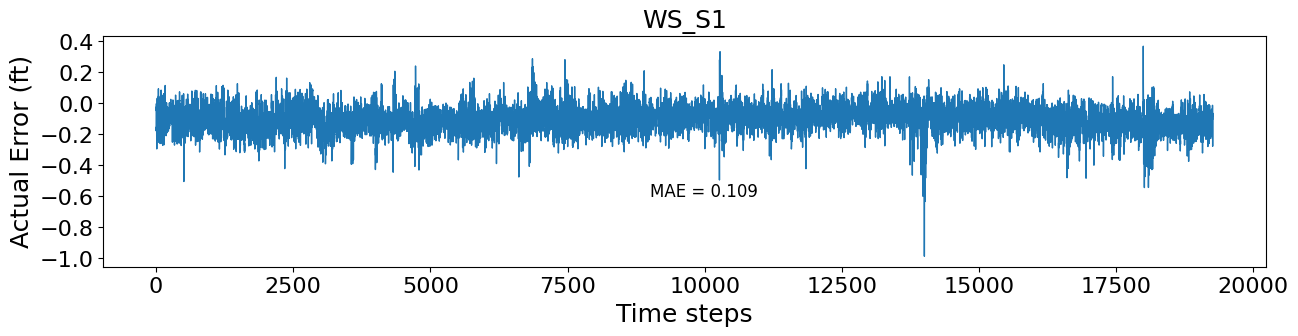

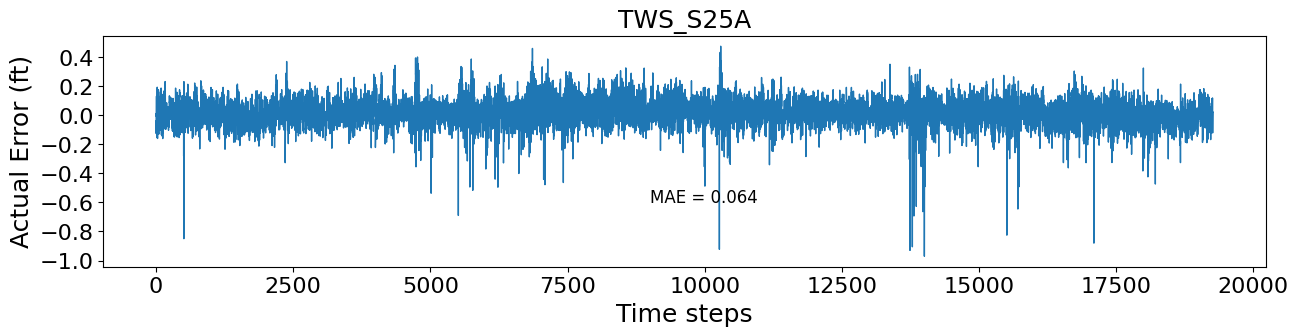

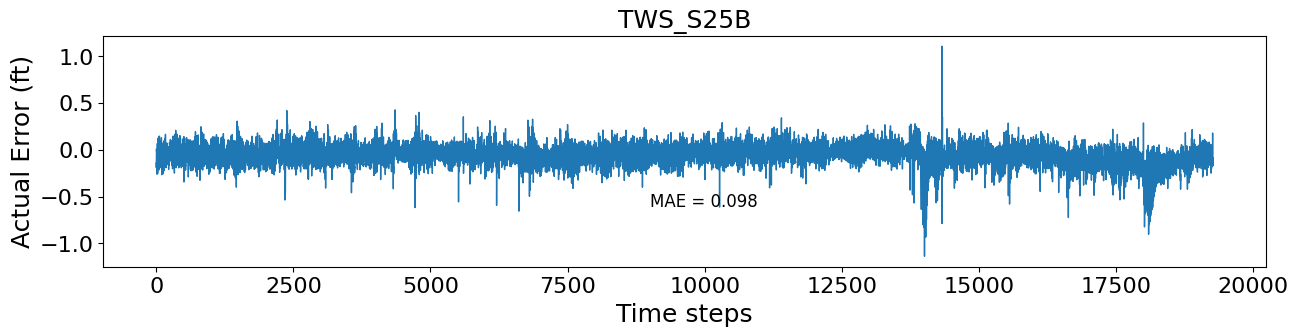

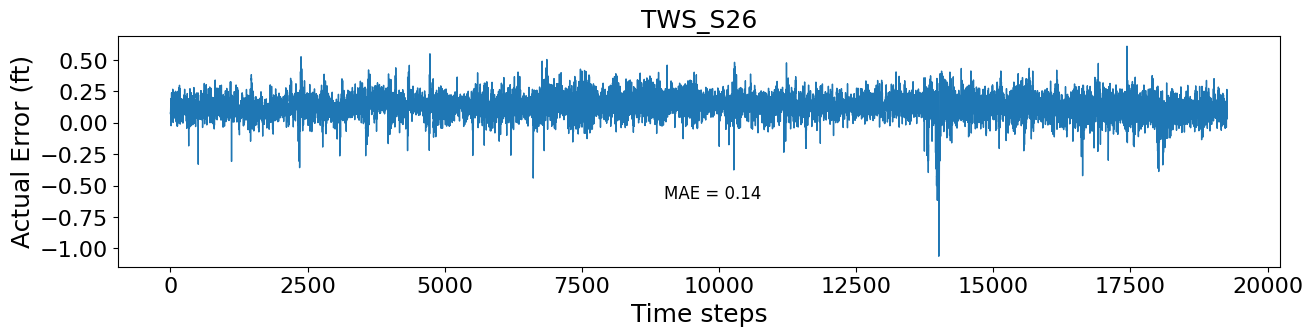

In [19]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [20]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
13
(19268,)
21
(19268,)
125
(19268,)
13


In [21]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
0
(19268,)
0
(19268,)
2
(19268,)
4


In [22]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
13
(19268,)
21
(19268,)
123
(19268,)
9
